In [1]:
!git clone https://github.com/sheelfshah/banditpylib.git
%cd banditpylib
!make install
!pip3 uninstall matplotlib
!pip3 install matplotlib==3.1.3

Cloning into 'banditpylib'...
remote: Enumerating objects: 7288, done.
remote: Counting objects: 100% (684/684), done.
remote: Compressing objects: 100% (342/342), done.
remote: Total 7288 (delta 504), reused 468 (delta 341), pack-reused 6604
Receiving objects: 100% (7288/7288), 10.53 MiB | 14.36 MiB/s, done.
Resolving deltas: 100% (5424/5424), done.


In [16]:
# run only if updating
%cd banditpylib
!git pull
!pip install -e .
# restart runtime

/content/banditpylib
Already up to date.
Obtaining file:///content/banditpylib
  Attempting uninstall: banditpylib
    Found existing installation: banditpylib 1.0.0
    Can't uninstall 'banditpylib'. No files were found to uninstall.
  Running setup.py develop for banditpylib


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tempfile
import seaborn as sns
import random
sns.set(style="darkgrid")

from banditpylib import trials_to_dataframe
from banditpylib.arms import GaussianArm
from banditpylib.bandits import MultiArmedBandit
from banditpylib.protocols import CollaborativeLearningProtocol, SinglePlayerProtocol
from banditpylib.learners.collaborative_learner import (
    LilUCBHeuristicCollaborativeBAIAgent as Agent,
    LilUCBHeuristicCollaborativeBAIMaster as Master,
    CollaborativeBAILearner as Learner
)
from banditpylib.learners.mab_fcbai_learner import LilUCBHeuristic

In [2]:
means = [(i/10)**0.5 for i in range(1,10)]
random.shuffle(means)
print(means)

[0.8366600265340756, 0.7071067811865476, 0.4472135954999579, 0.7745966692414834, 0.6324555320336759, 0.9486832980505138, 0.5477225575051661, 0.31622776601683794, 0.8944271909999159]


In [3]:
confidence = 0.99
num_learners, rounds, horizon = 10, 5, 30000
param_dict = {
    "rounds": [rounds] * num_learners,
    "horizon": [horizon] * num_learners,
    "num_agents": [2*(i + 1) for i in range(num_learners)]
}

arms = [GaussianArm(mu=mean, std=1) for mean in means]
bandit = MultiArmedBandit(arms=arms)
masters = [Master(arm_num=len(arms), rounds=param_dict["rounds"][i], horizon=param_dict["horizon"][i],
                  num_agents=param_dict["num_agents"][i], name="master %d" % (i+1)) for i in range(num_learners)]
agents = [Agent(arm_num=len(arms), rounds=param_dict["rounds"][i], horizon=param_dict["horizon"][i],
                name="agent %d" % (i+1)) for i in range(num_learners)]

learners = [Learner(agent=agents[i], master=masters[i], num_agents=param_dict["num_agents"][i],
                    name="learner %d" % (i+1)) for i in range(num_learners)]
trials = 5

In [4]:
game1 = CollaborativeLearningProtocol(bandit=bandit, learners=learners)
game1.play(trials=trials, output_filename="trial_outputs1.txt")
data_df1 = trials_to_dataframe("trial_outputs1.txt")
!rm trial_outputs1.txt

In [5]:
learners = [LilUCBHeuristic(len(arms), confidence)]
game2 = SinglePlayerProtocol(bandit=bandit, learners=learners, horizon=horizon)
game2.play(trials=trials, output_filename="trial_outputs2.txt")
data_df2 = trials_to_dataframe("trial_outputs2.txt")
!rm trial_outputs2.txt

In [6]:
data_df = pd.concat([data_df1, data_df2])
data_df["confidence"] = confidence

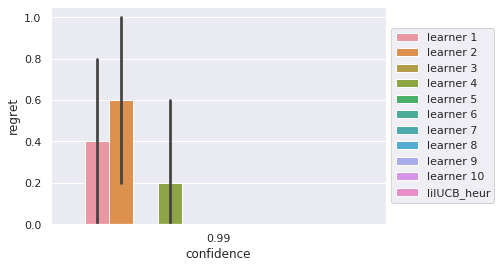

In [7]:
fig = plt.figure()
ax = plt.subplot(111)
sns.barplot(x='confidence', y='regret', hue='learner', data=data_df)
plt.ylabel('regret')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# non zero regret due to bug?

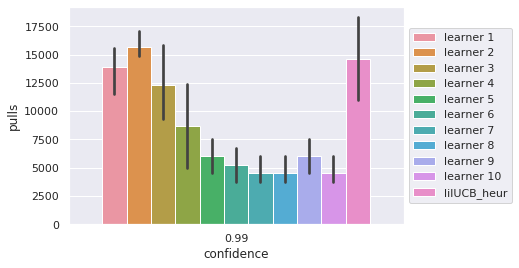

In [8]:
fig = plt.figure()
ax = plt.subplot(111)
sns.barplot(x='confidence', y='total_actions', hue='learner', data=data_df)
plt.ylabel('pulls')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# agents not fast enough ?